# Контентный анализ новостей трех источников : РИА Новости (https://ria.ru/), РБК (https://www.rbc.ru) и ЛЕНТА (https://lenta.ru/) за начало 2025 года. 

### Дипломная работа курса "Анализ данных" в ВШЭ. 
 

In [1]:
import os
import plotly
import plotly.graph_objects as go
import spacy
import pandas as pd
import numpy as np
import csv
import matplotlib.pyplot as plt
import seaborn as sns
import re
import nltk
import pymorphy2

In [2]:
from plotly.subplots import make_subplots
from nltk.corpus import stopwords
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from natasha import Segmenter, NewsNERTagger, NewsEmbedding, Doc, NewsMorphTagger
from natasha import NamesExtractor, MorphVocab, PER
from collections import Counter
from spacy.lang.ru.examples import sentences
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.metrics import confusion_matrix

В этом проекте я провожу сравнительный контентный анализ трёх крупных российских новостных источников. 

#### Цель — выявить различия в тематике, стиле подачи и частотности ключевых слов в публикациях за начало 2025 года. 

Анализ выполнен с применением инструментов NLP: тематического моделирования, NER и морфологического анализа.

## Сбор и обработка Datasetа. 

Материал собран с трех новостных сайтов РИА Новости, РБК и Лента.ру. 

Датасет собран парсингом с трех ресурсов за начало 2025г. Осноные библиотеки BeautifulSoup и Selenium. Собранные данные были сохранены в csv файлы для дальнейшей работы. Код для парсинга собран в отдельном ноутбуке "Парсинг новостей"

Загрузка данных из файлов, просмотр пустых значений, добавление названий столбцов для удобства дальнейшей работы. 

In [20]:
ria = pd.read_csv('ria.csv')
rbk = pd.read_csv('rbk.csv')
lenta = pd.read_csv('lenta.csv')
rbk['2'], rbk['3'] = rbk['3'], rbk['2'] #перепутала при парсинге
ria['5'] = ria['5'].str.replace(r'^.*?РИА Новости\.', '', regex=True)
ria.insert(0, "11", 'РИА')
rbk.insert(0, "11", 'РБК')
lenta.insert(0, "11", 'ЛЕНТА')
news = pd.concat([ria, rbk, lenta])
news = news.reset_index(drop=True)
news.columns = ["media", "link", "date_time", "title", "kaywords", "rubrics", "text", "author"]
news.head()

,media,link,date_time,title,kaywords,rubrics,text,author
0,РИА,https://ria.ru/20250103/uran-1992449771.html,2025-01-03 23:59:00,Импорт урана из России в Германию вырос почти ...,"В мире, Германия, Украина, Россия, Роберт Хабе...",В мире,Импорт урана из Российской Федерации в Германи...,NaN
1,РИА,https://ria.ru/20250103/avstriya-1992449572.html,2025-01-03 23:51:00,Президент Австрии призвал продолжить работу на...,"В мире, Австрия, Александер Ван дер Беллен, Ка...",В мире,Австрийская народная партия (АНП) и Социал-дем...,NaN
2,РИА,https://ria.ru/20250103/trevoga-1992449401.html,2025-01-03 23:46:00,В Курской области объявили ракетную опасность,"Специальная военная операция на Украине, Курск...",NaN,Ракетная опасность объявлена в Курской области...,NaN
3,РИА,https://rsport.ria.ru/20250103/rotenberg-19924...,2025-01-03 23:43:00,Ротенберг рассказал об атмосфере на матче СКА ...,"Хоккей, Ванкувер, Канада, Роман Ротенберг, СКА...",NaN,Главный тренер петербургского СКА Роман Ротенб...,NaN
4,РИА,https://ria.ru/20250103/trevoga-1992449126.html,2025-01-03 23:40:00,В Белгородской области объявили ракетную опасн...,"Специальная военная операция на Украине, Белго...",NaN,Ракетная опасность объявлена на всей территори...,NaN


На новостных сайтах имя автора статей прописывалось только у издания Лента.ру. 

In [21]:
news.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 863 entries, 0 to 862
Data columns (total 8 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   media      863 non-null    object
 1   link       863 non-null    object
 2   date_time  794 non-null    object
 3   title      857 non-null    object
 4   kaywords   439 non-null    object
 5   rubrics    809 non-null    object
 6   text       813 non-null    object
 7   author     355 non-null    object
dtypes: object(8)
memory usage: 54.1+ KB


In [22]:
news.shape

(863, 8)

In [23]:
news.isnull().sum()

media          0
link           0
date_time     69
title          6
kaywords     424
rubrics       54
text          50
author       508
dtype: int64

Больше всего нас интересуют колонки title и text, основной анализ будет проводиться по этим столбцам. 

Проверим сначала строки у которых нет заголовка (title), их всего 6.

In [25]:
news['title_2'] = np.where(news['title'].isnull(), 0,1)
news[news.title_2 == 0]

,media,link,date_time,title,kaywords,rubrics,text,author,title_2
248,РБК,https://www.rbc.ru/wine?utm_source=rbc&utm_med...,NaN,NaN,NaN,NaN,В разгаре русский народный праздник — Маслениц...,NaN,0
342,РБК,https://www.rbc.ru/industries/news/67bf35769a7...,NaN,NaN,NaN,NaN,Изучать некоторые индийские религии теперь мож...,NaN,0
387,РБК,https://www.rbc.ru/industries/?utm_source=topline,NaN,NaN,NaN,NaN,Импортозамещение способствовало увеличению акт...,NaN,0
438,РБК,https://www.rbc.ru/industries/news/67bebf309a7...,NaN,NaN,NaN,NaN,Индийский рынок рекламы огромен. Однако разобр...,NaN,0
443,РБК,https://www.rbc.ru/industries/news/67bf35769a7...,NaN,NaN,NaN,NaN,Изучать некоторые индийские религии теперь мож...,NaN,0
482,РБК,https://www.rbc.ru/industries/news/67bebf309a7...,NaN,NaN,NaN,NaN,Индийский рынок рекламы огромен. Однако разобр...,NaN,0


Теперь проверим строки где нет текста (text).

In [26]:
news['text_2'] = np.where(news['text'].isnull(), 0,1)
news[news.text_2 == 0].head()

,media,link,date_time,title,kaywords,rubrics,text,author,title_2,text_2
246,РБК,https://www.rbc.ru/quote/ticker/59818?utm_sour...,NaN,BELU,NaN,РБК Инвестиции,NaN,NaN,1,0
249,РБК,https://www.rbc.ru/contacts/,NaN,Контакты — РБК,NaN,РБК,NaN,NaN,1,0
255,РБК,https://www.rbc.ru/quote/ticker/59325?utm_sour...,NaN,MAGN,NaN,РБК Инвестиции,NaN,NaN,1,0
257,РБК,https://www.rbc.ru/quote/ticker/357769,NaN,ALL,NaN,РБК Инвестиции,NaN,NaN,1,0
259,РБК,https://www.rbc.ru/quote/ticker/72413,NaN,USD,NaN,РБК Инвестиции,NaN,NaN,1,0


Проверим к каким медиа относятся строки с отстутвующим текстом. 

In [27]:
news[news["text_2"] == 0]["media"].unique()

array(['РБК'], dtype=object)

Все случаи относяться к РБК, скорей всего это связано с несовершенством парсинга и устройством сайта. 
Поскольку текст публикации отсутствует удалим эти строки.

In [28]:
news = news.dropna(subset=['text'])
news[news.text_2 == 0].head()

,media,link,date_time,title,kaywords,rubrics,text,author,title_2,text_2


Удалим ненужные столбцы, которые использовали для проверки. 

In [29]:
news.drop(['text_2', 'title_2'], axis = 1, inplace = True)
news.head()

,media,link,date_time,title,kaywords,rubrics,text,author
0,РИА,https://ria.ru/20250103/uran-1992449771.html,2025-01-03 23:59:00,Импорт урана из России в Германию вырос почти ...,"В мире, Германия, Украина, Россия, Роберт Хабе...",В мире,Импорт урана из Российской Федерации в Германи...,NaN
1,РИА,https://ria.ru/20250103/avstriya-1992449572.html,2025-01-03 23:51:00,Президент Австрии призвал продолжить работу на...,"В мире, Австрия, Александер Ван дер Беллен, Ка...",В мире,Австрийская народная партия (АНП) и Социал-дем...,NaN
2,РИА,https://ria.ru/20250103/trevoga-1992449401.html,2025-01-03 23:46:00,В Курской области объявили ракетную опасность,"Специальная военная операция на Украине, Курск...",NaN,Ракетная опасность объявлена в Курской области...,NaN
3,РИА,https://rsport.ria.ru/20250103/rotenberg-19924...,2025-01-03 23:43:00,Ротенберг рассказал об атмосфере на матче СКА ...,"Хоккей, Ванкувер, Канада, Роман Ротенберг, СКА...",NaN,Главный тренер петербургского СКА Роман Ротенб...,NaN
4,РИА,https://ria.ru/20250103/trevoga-1992449126.html,2025-01-03 23:40:00,В Белгородской области объявили ракетную опасн...,"Специальная военная операция на Украине, Белго...",NaN,Ракетная опасность объявлена на всей территори...,NaN


In [1]:
news.shape

NameError: name 'news' is not defined

### Нормализация текста, удаление стоп-слов, дат

Очистим основной текст (text) и заголовок (title) для дальнейшей работы. Будем удалять знаки препинания, слова паразиты и лишние даты из текста.

In [30]:
nltk.download('stopwords') 
russian_stopwords = set(stopwords.words('russian'))

date_pattern = r'\b\d{1,2}[\s./-]?(января|февраля|марта|апреля|мая|июня|июля|августа|сентября|октября|ноября|декабря)?[\s./-]?\d{2,4}?\b|\b\d{4} год\b'

def clean_text(text):
    if pd.isna(text):
        return "" 

    text = re.sub(date_pattern, '', text, flags=re.IGNORECASE)
    text = re.sub(r'\s+', ' ', text)  
    text = re.sub(r'[^\w\s\-]', '', text)  
    words = text.split()
    words = [word for word in words if word not in russian_stopwords]  
    return " ".join(words)

news['title_clean'] = news['title'].apply(clean_text)
news['text_clean'] = news['text'].apply(clean_text)

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\malen\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Приведем даты и время публикаций в формат даты и добавим отдельный столбец "hour".

In [32]:
news["date_time"] = pd.to_datetime(news["date_time"])
news["hour"] = news["date_time"].dt.hour

Еще два дополнительных шага: "рубрики" - делаем единый формат для рубрик "в мире" и "мир", а также добавим столбец "text_length" - показывающий длинну публикаций. 

In [33]:
news['rubrics'] = news['rubrics'].replace({'В мире': 'Мир'})
news["text_length"] = news["text_clean"].apply(len)

Собранный датасет готов к работе, можно переходить к исследованиям. 

## Исследования собранных данных 

### Время публикации статей для каждого СМИ

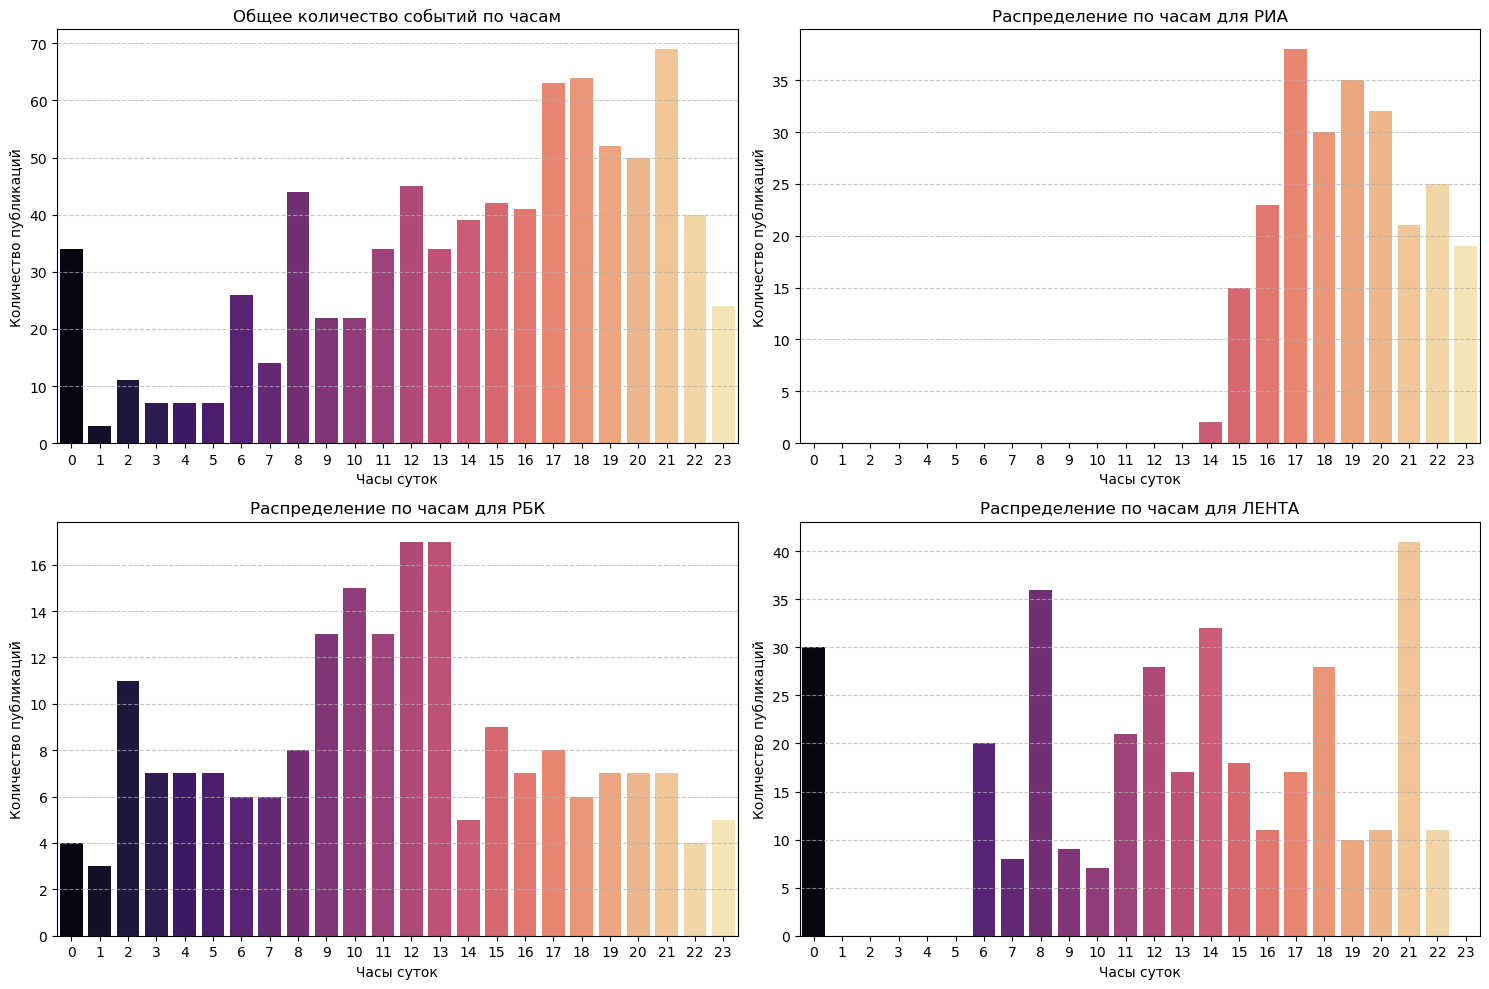

In [34]:
event_counts = news.groupby("hour").size().reindex(range(24), fill_value=0)

fig, axs = plt.subplots(2, 2, figsize=(15, 10))

# Общий график
sns.barplot(x=event_counts.index, y=event_counts.values, palette="magma", ax=axs[0, 0])
axs[0, 0].set_xlabel("Часы суток")
axs[0, 0].set_ylabel("Количество публикаций")
axs[0, 0].set_title("Общее количество публикаций в час")
axs[0, 0].set_xticks(range(24))
axs[0, 0].set_xticklabels([str(i) for i in range(24)])
axs[0, 0].grid(axis="y", linestyle="--", alpha=0.7)

#графики для каждого СМИ
media_groups = news['media'].unique()

for i, media in enumerate(media_groups):
    event_counts_media = (
        news[news['media'] == media]
        .groupby("hour")
        .size()
        .reindex(range(24), fill_value=0)
    )
    
    row, col = (i + 1) // 2, (i + 1) % 2
    sns.barplot(x=event_counts_media.index, y=event_counts_media.values, palette="magma", ax=axs[row, col])
    axs[row, col].set_xlabel("Часы суток")
    axs[row, col].set_ylabel("Количество публикаций")
    axs[row, col].set_title(f"Распределение по часам для {media}")
    axs[row, col].set_xticks(range(24))
    axs[row, col].set_xticklabels([str(i) for i in range(24)])
    axs[row, col].grid(axis="y", linestyle="--", alpha=0.7)

plt.tight_layout()
plt.show()

По полученным данным можно сказать, что во-первых наибольшее количество новостей публикуется в вечернее время это связано с интенсивностью событий в течении для и активностью аудитории сайтов. Во-вторых, распределение по времени публикации для РИА Новостей не показательно, так как парсинг осуществлялся из архивного раздела, в архив попадают не все новости публикующиеся на сайте. Наиболее полное распределение удалось получить для сайта РБК, где наибольшее количество статей публикуется в 12-13 часов дня. Лента.ру публикует новости с 6 утра до 12 ночи. 

### Средняя длинна статей для разных медиа

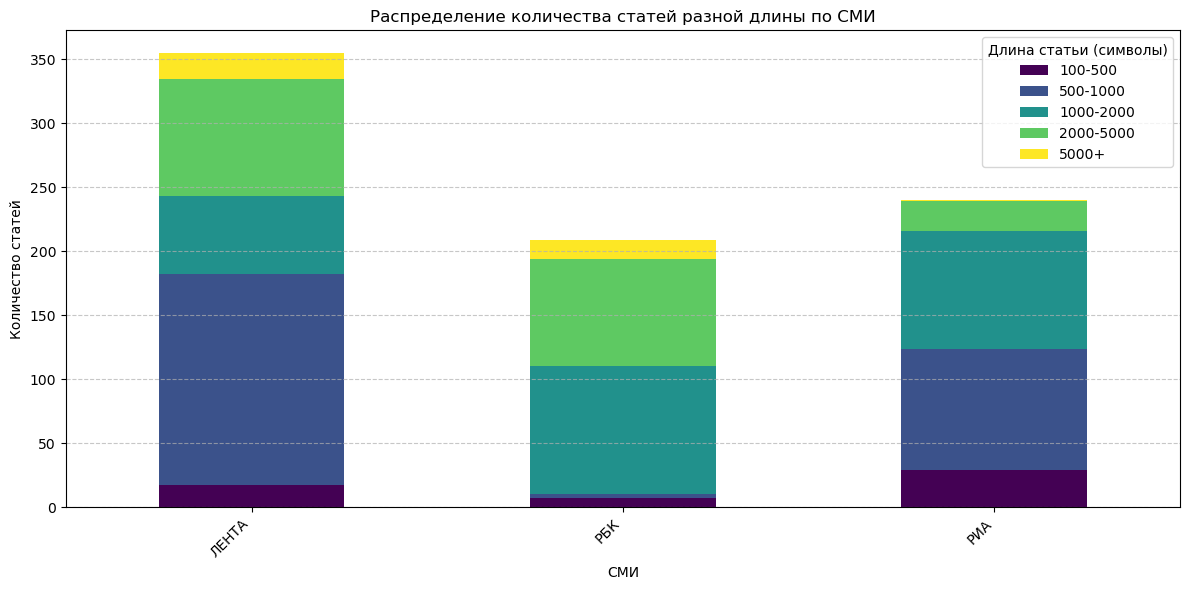

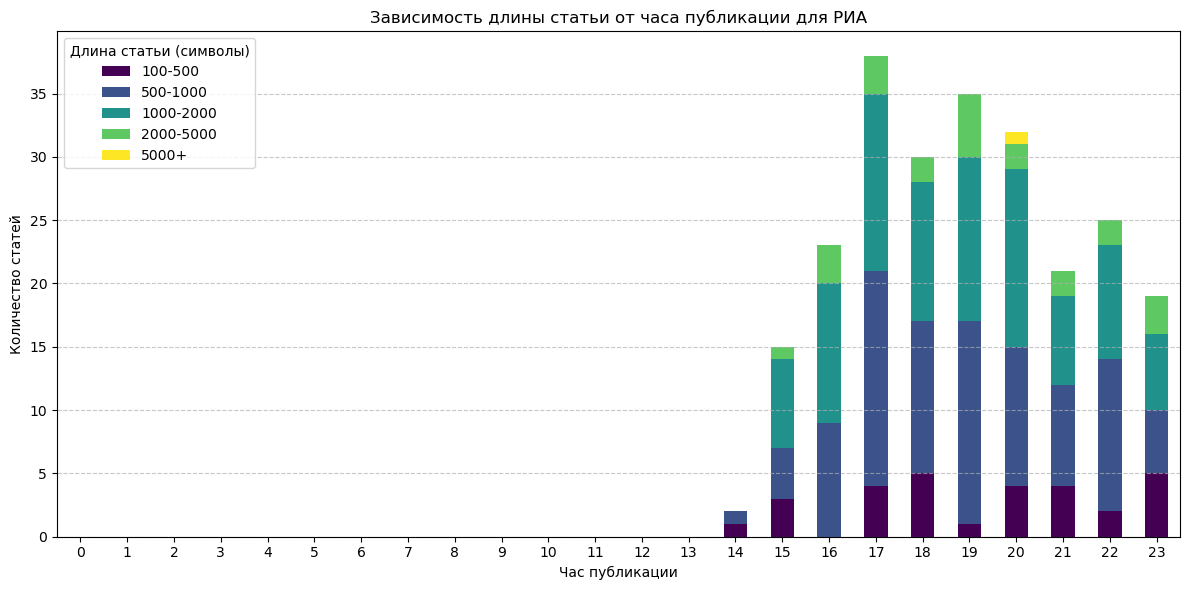

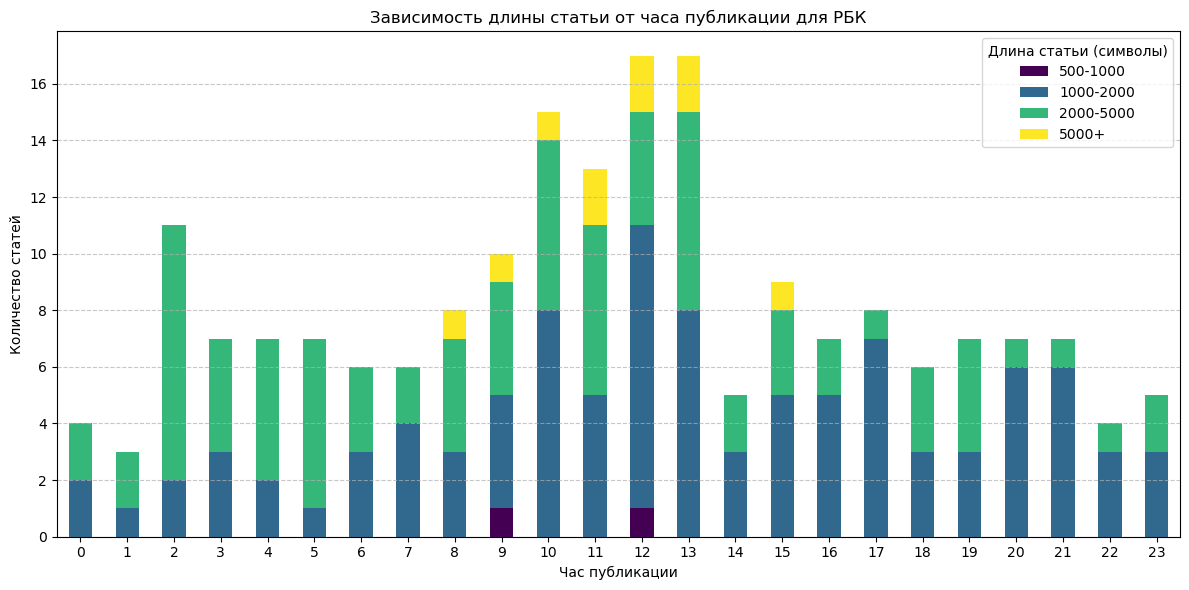

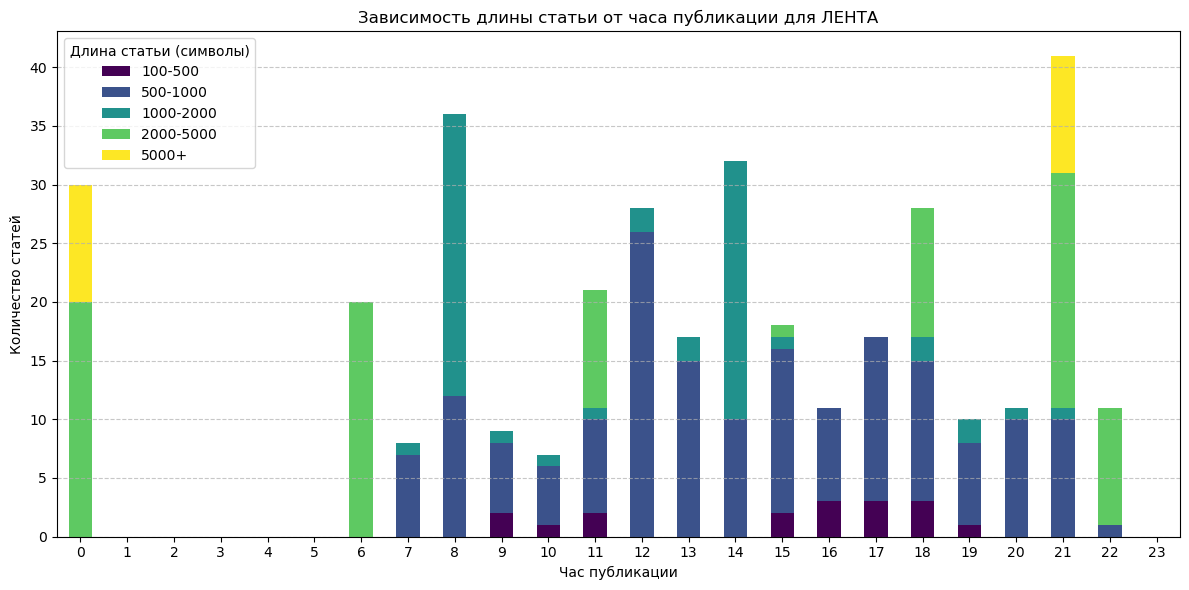

In [35]:
bins = [100, 500, 1000, 2000, 5000, 10000]
labels = ["100-500", "500-1000", "1000-2000", "2000-5000", "5000+"]

filtered_news = news[news["text_length"] > 100].copy()
filtered_news["length_category"] = pd.cut(filtered_news["text_length"], bins=bins, labels=labels, right=False)

# 1
length_counts = filtered_news.groupby(["media", "length_category"]).size().unstack(fill_value=0)

length_counts.plot(kind="bar", stacked=True, figsize=(12, 6), colormap="viridis")
plt.title("Распределение количества статей разной длины по СМИ")
plt.xlabel("СМИ")
plt.ylabel("Количество статей")
plt.xticks(rotation=45, ha="right")
plt.legend(title="Длина статьи (символы)")
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.tight_layout()
plt.show()

#2
media_list = filtered_news["media"].unique()

for media in media_list:
    media_data = filtered_news[filtered_news["media"] == media]
    
    length_by_hour = pd.crosstab(media_data["hour"], media_data["length_category"]).reindex(range(24), fill_value=0)
    
    length_by_hour.plot(kind="bar", stacked=True, figsize=(12, 6), colormap="viridis")
    plt.title(f"Зависимость длины статьи от часа публикации для {media}")
    plt.xlabel("Час публикации")
    plt.ylabel("Количество статей")
    plt.xticks(rotation=0)
    plt.legend(title="Длина статьи (символы)")
    plt.grid(axis="y", linestyle="--", alpha=0.7)
    plt.tight_layout()
    plt.show()

По графикам видно: новостные публикации на сайте РИА новости выходят с 14 до 23 часов с пиком в 17 часов, что можно объяснить оптимальным временем для потребителей контента сайта. РБК публикует новости круглосуточно можно выделить повышение активности в первой половине дня с 9 до 13 с пиком в 12-13 часов. с 8 утра до 13 вместе с другими материалами публикаются лонгриды. И дополнительно лонгриды публикуются в 15 часов.  Лента.ру публикует новости с 6 утра до 12 ночи с двумя пиками в 8 утра и 9 вечера. В 12 ночи публикуется тоже много статей. Лонгриды в Лента.ру публикуются 2 раза в сутки в полночь и в 9 вечера. 

Посмотрим еще среднюю и медианную длинну статей для каждого медиа.

In [38]:
news.groupby("media")['text_length'].mean()

media
ЛЕНТА    1928.101408
РБК      2670.577982
РИА      1113.429167
Name: text_length, dtype: float64

In [39]:
news.groupby("media")['text_length'].median()

media
ЛЕНТА     976.0
РБК      1912.0
РИА       947.0
Name: text_length, dtype: float64

Средняя длина статьи: РБК - 2670.58 символов, Лента.ру - 1928.10 символов, РИА Новости - 1113.43 символов. 
Медианные значения длин статей: РБК - 1912 символов, Лента.ру - 976 символов, РИА Новости - 947 символов. 

### Рубрикация публикаций РИА Новости и Лента.ру

<Figure size 1200x600 with 0 Axes>

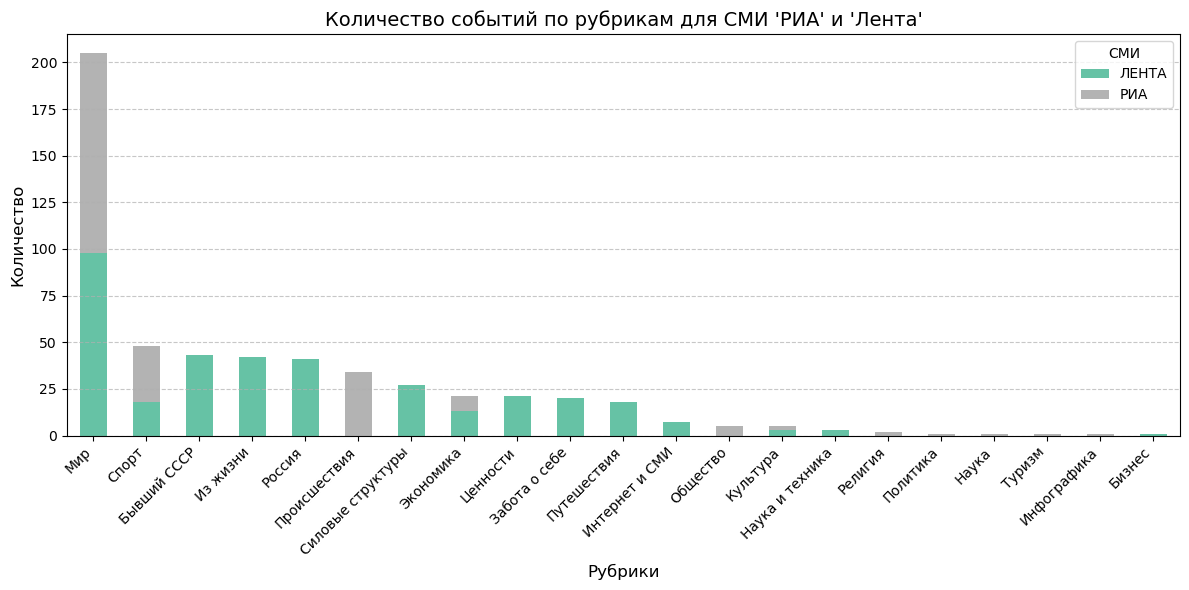

In [40]:
filtered_news = news[news['media'].isin(['РИА', 'ЛЕНТА'])]

rubric_counts = filtered_news.groupby(['rubrics', 'media']).size().unstack(fill_value=0)

rubric_counts["total"] = rubric_counts.sum(axis=1)
rubric_counts = rubric_counts.sort_values(by="total", ascending=False).drop(columns="total")

plt.figure(figsize=(12, 6))
rubric_counts.plot(kind='bar', stacked=True, colormap="Set2", figsize=(12, 6))

plt.xlabel("Рубрики", fontsize=12)
plt.ylabel("Количество", fontsize=12)
plt.title("Количество событий по рубрикам для СМИ 'РИА' и 'Лента'", fontsize=14)
plt.xticks(rotation=45, ha='right') 
plt.legend(title="СМИ")
plt.grid(axis='y', linestyle="--", alpha=0.7)

plt.tight_layout()
plt.show();

Сайт РБК использует отличную структуру рубрикации, поэтому был исключен из сравнения. 
Рубрики в Лента.ру и РИА Новости похожи, оба новостных издания большее внимание уделяют общемеровым новостям, при этом в эту категорию для РИА Новостей попадают российские новости и у обоих изданий в эту категорию относятся публикации о конфликте с Украиной. Лента.ру имеет более подробную рубрикацию, чем РИА Новости. 

## Named Entity Recognition (NER)

Посмотрим какие главные ТОП-10 персон, мест и компаний упоминаются в исследуемых медиа в начале 2025 г.

In [45]:
segmenter = Segmenter()
morph_vocab = MorphVocab()
emb = NewsEmbedding()
morph_tagger = NewsMorphTagger(emb)
ner_tagger = NewsNERTagger(emb)
names_extractor = NamesExtractor(morph_vocab)

# Список дополнительно удаляемых слов
stop_names = {"как", "чего", "кто", "она", "они", "он", "мне", "тебе", "её", "ему"}

def extract_names_natasha(text):
    doc = Doc(text)
    doc.segment(segmenter)
    doc.tag_morph(morph_tagger)
    doc.tag_ner(ner_tagger)

    names = []
    for span in doc.spans:
        if span.type == "PER": 
            span.normalize(morph_vocab) 
            normalized_name = span.normal.strip()

            if normalized_name.lower() not in stop_names and len(normalized_name) > 2:
                split_names = re.split(r'\s+', normalized_name)
                names.extend(split_names if len(split_names) <= 2 else [])  
    return names

def extract_countries_natasha(text):
    doc = Doc(text)
    doc.segment(segmenter)
    doc.tag_morph(morph_tagger)
    doc.tag_ner(ner_tagger)

    countries = []
    for span in doc.spans:
        if span.type == "LOC":  
            span.normalize(morph_vocab)
            countries.append(span.normal)
    return countries

def extract_companies_natasha(text):
    doc = Doc(text)
    doc.segment(segmenter)
    doc.tag_morph(morph_tagger)
    doc.tag_ner(ner_tagger)

    companies = []
    for span in doc.spans:
        if span.type == "ORG":
            span.normalize(morph_vocab)
            companies.append(span.normal) 
    return companies

news['names_title'] = news['title_clean'].dropna().apply(extract_names_natasha)
news['names_text'] = news['text_clean'].dropna().apply(extract_names_natasha)

news['countries_title'] = news['title'].dropna().apply(extract_countries_natasha)
news['countries_text'] = news['text'].dropna().apply(extract_countries_natasha)

news['companies_title'] = news['title'].dropna().apply(extract_companies_natasha)
news['companies_text'] = news['text'].dropna().apply(extract_companies_natasha)

all_names = [name for names in news['names_title'].dropna() for name in names] + \
            [name for names in news['names_text'].dropna() for name in names]

all_countries = [country for countries in news['countries_title'].dropna() for country in countries] + \
                [country for countries in news['countries_text'].dropna() for country in countries]

all_companies = [company for companies in news['companies_title'].dropna() for company in companies] + \
                [company for companies in news['companies_text'].dropna() for company in companies]

top_names = Counter(all_names).most_common(10)
top_countries = Counter(all_countries).most_common(10)
top_companies = Counter(all_companies).most_common(10)

In [46]:
print("Топ-10 упоминаемых персон:", top_names)

Топ-10 упоминаемых персон: [('Зеленский', 1684), ('Трамп', 1533), ('Мэри', 260), ('Вэнс', 244), ('Владимир', 242), ('Вэнса', 196), ('Маск', 186), ('Сент-Клер', 170), ('Маска', 166), ('Шарлотта', 160)]


In [47]:
print("Топ-10 упоминаемых стран:", top_countries)

Топ-10 упоминаемых стран: [('США', 953), ('Украина', 889), ('Россия', 599), ('Белый дом', 575), ('Вашингтон', 207), ('Китай', 204), ('Как', 190), ('Киев', 150), ('Европа', 132), ('Абхазия', 129)]


In [48]:
print("Топ-10 упоминаемых компаний:", top_companies)

Топ-10 упоминаемых компаний: [('РБК', 576), ('Telegram', 525), ('Госдепартамент', 195), ('Домодедово', 190), ('НАТО', 169), ('ВСУ', 155), ('Toyota', 86), ('Лента.ру', 76), ('Минобороны', 70), ('X', 68)]


В целом модель сработала корректно. Произошла путаница с "Маск" и "Маска" и среди мест "Как". Это связано с предобработкой текста. 

Топ-10 политиков, мест и стран хорошо показывает, что основная тематика месяца Внешняя политика. 

## Анализ: Тематическое моделирование (LDA)

### Какая самая популярная тема месяца?

Попробуем с помощью методов машинного обучения определить главную тему, рассматриваемого периода. Определять тему будем на основе наборов из топ-10 слов. 

Перед моделированием, очистим и лемматизируем текст, то есть приведем все слова в тексте к их базовым формам с учетом контекста. 

Для этого дополнительно создадим функцию normalize_and_filter.

In [51]:
morph = pymorphy2.MorphAnalyzer()

exclude_words = {"как", "это", "этот", "также", "рбк","telegram", "который", "cookie", "the", "or"}

def normalize_and_filter(text):
    if pd.isna(text):
        return ""

    words = text.lower().split()
    normalized_words = []

    for word in words:
        parsed = morph.parse(word)[0]
        lemma = parsed.normal_form

        if lemma not in exclude_words:
            normalized_words.append(lemma)

    return " ".join(normalized_words)

In [52]:
news['combined_text'] = news['title_clean'] + " " + news['text_clean']
news['combined_text'] = news['combined_text'].apply(normalize_and_filter)

vectorizer = CountVectorizer(max_features=5000, stop_words=list(russian_stopwords))
X = vectorizer.fit_transform(news['combined_text'].dropna())

lda = LatentDirichletAllocation(n_components=5, random_state=42)
lda.fit(X)

words = vectorizer.get_feature_names_out()
for i, topic in enumerate(lda.components_):
    print(f"Тема {i+1}: ", [words[j] for j in topic.argsort()[-10:]])

Тема 1:  ['россия', 'канал', 'область', 'перепалка', 'вэнс', 'сша', 'российский', 'год', 'зеленский', 'трамп']
Тема 2:  ['рынок', 'однако', 'остров', 'стать', 'ребёнок', 'монах', 'россия', 'шалам', 'свой', 'год']
Тема 3:  ['встреча', 'заявить', 'американский', 'дом', 'белый', 'президент', 'сша', 'украина', 'трамп', 'зеленский']
Тема 4:  ['человек', 'сента', 'клера', 'жизнь', 'шарлотта', 'время', 'слово', 'ребёнок', 'мэри', 'год']
Тема 5:  ['страна', 'сообщить', 'российский', 'свой', 'газ', 'человек', 'сайт', 'данные', 'информация', 'год']


Выделим самую популярную:

In [53]:
topic_distribution = lda.transform(X)
dominant_topic = topic_distribution.argmax(axis=1)

most_common_topic = pd.Series(dominant_topic).value_counts().idxmax()
print(f"Самая популярная тема месяца: Тема {most_common_topic+1}")

Самая популярная тема месяца: Тема 1


Дадим название темам по ключевым словам и попробуем разделить все имеющиеся публикации по темам. 

In [54]:
topic_labels = {
    0: "Политическое противостояние России и США",
    1: "Общество и культура в России",
    2: "Украина, США и международная дипломатия",
    3: "Человеческие истории и драма",
    4: "Информационная безопасность и ресурсы государства"
}

topic_words = {}
feature_names = vectorizer.get_feature_names_out()
for topic_idx, topic in enumerate(lda.components_):
    top_words = [feature_names[i] for i in topic.argsort()[:-11:-1]]
    topic_words[topic_labels[topic_idx]] = top_words

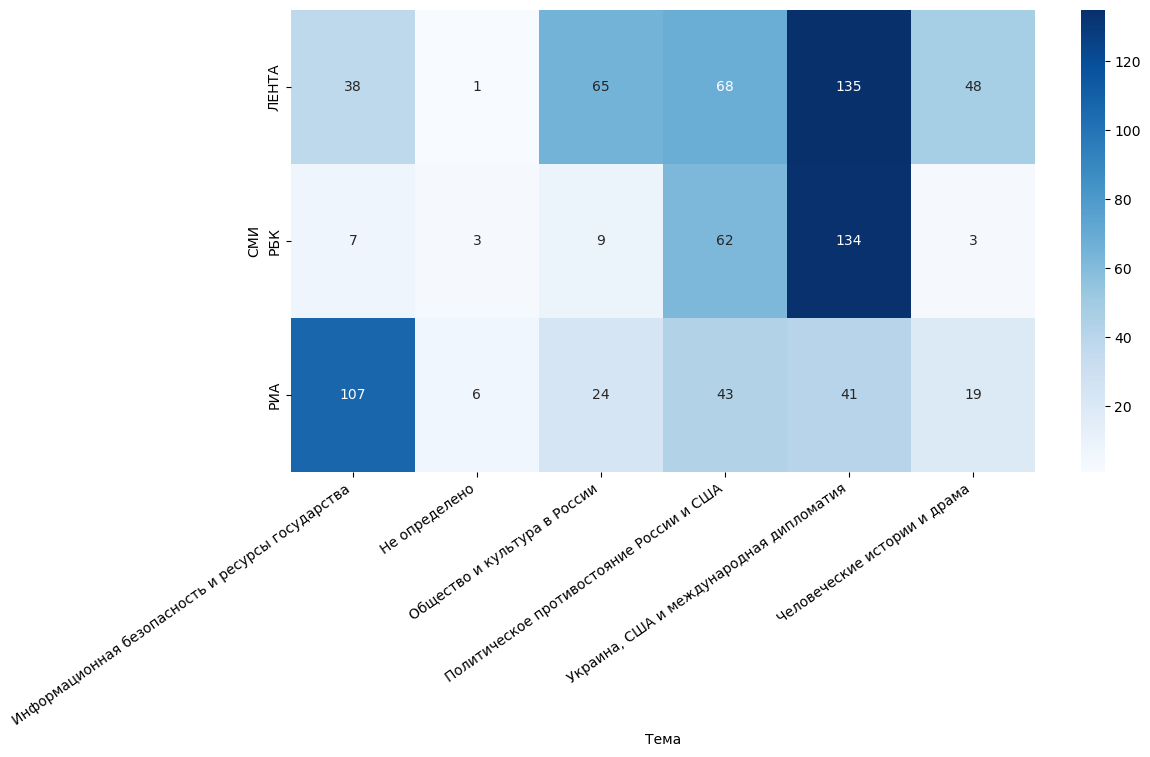

In [55]:
def assign_topic(text, topics_dict):
    if pd.isna(text):
        return "Не определено"

    words = set(text.split())
    max_matches = 0
    assigned_topic = "Не определено"

    for topic, keywords in topics_dict.items():
        matches = len(words.intersection(keywords))
        if matches > max_matches:
            max_matches = matches
            assigned_topic = topic

    return assigned_topic

news["assigned_topic"] = news["combined_text"].apply(lambda x: assign_topic(x, topic_words))

topic_distribution = news.groupby(["media", "assigned_topic"]).size().unstack().fillna(0)
plt.figure(figsize=(12, 6))
sns.heatmap(topic_distribution, cmap="Blues", annot=True, fmt=".0f")
plt.xlabel("Тема")
plt.ylabel("СМИ")
plt.xticks(rotation=35, ha="right")
plt.show()

По 10 ключевым словам удалось выделить 5 основных тематик.

Тема 1 "Политическое противостояние России и США",
Тема 2 "Общество и культура в России",
Тема 3: "Украина, США и международная дипломатия",
Тема 4: "Человеческие истории и драма",
Тема 5: "Информационная безопасность и ресурсы государства"

Темы 1 и Тема 3 достаточно близкие по смыслу и содержат очень похожий набор слов.  
 

Тема 1 "Политическое противостояние России и США" самая популярная тема начала 2025 г. во всех исследуемых СМИ по результатам LDA, при графической обработке, можно заметить что самая популярная Тема 3: "Украина, США и международная дипломатия". 

Для издания Лента.ру не удалось классифицировать 1 статью, для РИА Новостей количество статей для которых не удалось установить тему составило 6, для РБК 3. Эти различия связаны с качеством исходного текста. Лента.ру использует русский язык хорошего уровня, не перегруженный витиеватыми речевыми оборотами, который достаточно просто обрабатывать. РИА Новости имеет более низкое качество публикаций, но при этом при удалении слов паразитов тоже достаточно хорошо обрабатывается. Для РБК характерны большие статьи с большим количеством различных речевых оборотов, что усложняет компьютерную обработку. 

### Сравнение заголовков и текста – Соответствуют ли кликбейтные заголовки содержанию статьи?

In [56]:
morph = pymorphy2.MorphAnalyzer()

def lemmatize(text):
    words = text.split()
    lemmatized_words = [morph.parse(word)[0].normal_form for word in words]
    return ' '.join(lemmatized_words)

news['lemmatized_title'] = news['title_clean'].apply(lemmatize)
news['lemmatized_text'] = news['text_clean'].apply(lemmatize)

news["title_topic"] = news["lemmatized_title"].apply(lambda x: assign_topic(x, topic_words))
news["text_topic"] = news["lemmatized_text"].apply(lambda x: assign_topic(x, topic_words))

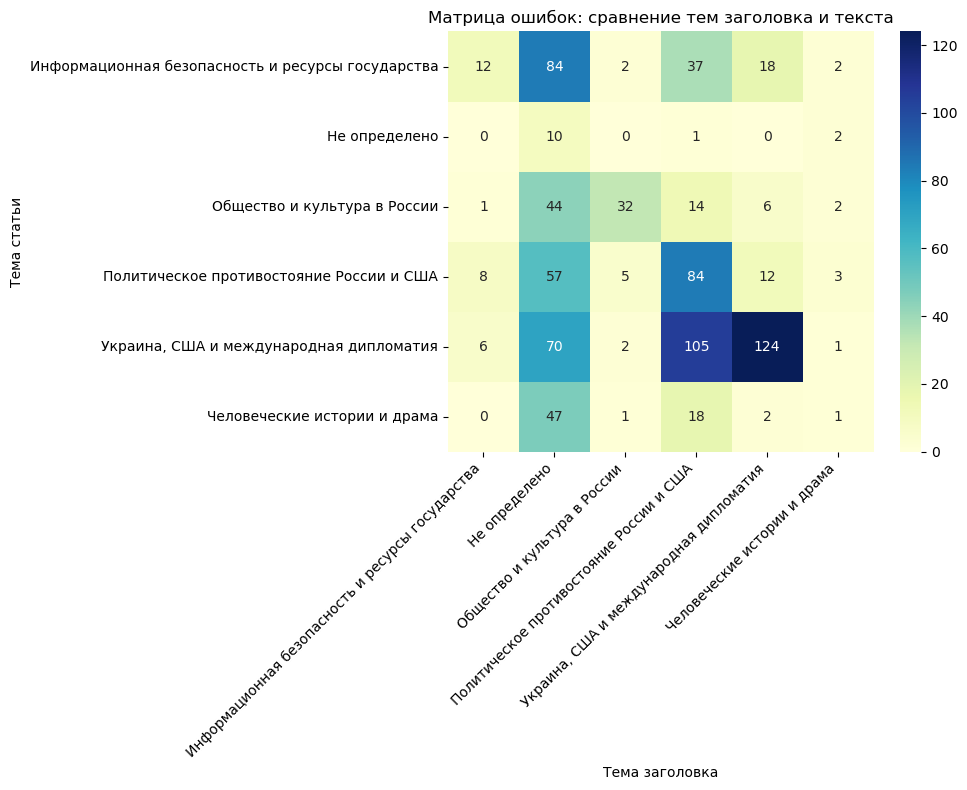

Общая точность совпадения тем: 32.35%

Точность по каждой теме:


,Точность темы
Не определено,76.92%
Политическое противостояние России и США,49.70%
"Украина, США и международная дипломатия",40.26%
Общество и культура в России,32.32%
Информационная безопасность и ресурсы государства,7.74%
Человеческие истории и драма,1.45%


In [57]:
df_topics = news.dropna(subset=["title_topic", "text_topic"])
y_true = df_topics["text_topic"]
y_pred = df_topics["title_topic"]
labels = sorted(set(y_true) | set(y_pred))

cm = confusion_matrix(y_true, y_pred, labels=labels)

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt="d", cmap="YlGnBu", xticklabels=labels, yticklabels=labels)
plt.xlabel("Тема заголовка")
plt.ylabel("Тема статьи")
plt.title("Матрица ошибок: сравнение тем заголовка и текста")
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

cm_df = pd.DataFrame(cm, index=labels, columns=labels)
accuracies = {}

for label in labels:
    true_total = cm_df.loc[label].sum()
    correct = cm_df.loc[label, label]
    accuracy = correct / true_total if true_total > 0 else np.nan
    accuracies[label] = accuracy

accuracy_df = pd.DataFrame.from_dict(accuracies, orient='index', columns=['Точность темы'])
accuracy_df = accuracy_df.sort_values(by='Точность темы', ascending=False)

overall_accuracy = (np.trace(cm) / np.sum(cm)) * 100

print(f"Общая точность совпадения тем: {overall_accuracy:.2f}%\n")
print("Точность по каждой теме:")
display(accuracy_df.style.format("{:.2%}"))

Общая точность совпадения тем и заголовком 32.35%, низкая точность скорей всего связана с определением темы заголовка. Темы заголовков по заданным параметрам в целом определялась хуже, потому что заголовок мог состоять всего из нескольких слов, отражающих смысл статьи, но не классифицируемый именно машинными методами по имеющимся наборам слов. 

Для текстов статей определение тематики было достаточно хорошим. Всего 10 статей не удалось классифицировать. 

### Выводы: 

Было собрано 863 строки новостных материалов с сайтов РИА Новости, РБК и Лента.ру. После анализа собранных данных было удалено 50 строк с сайта РБК, так как они не содержали текста статьей. Итоговый датасет содержал 813 строк.

По проанализированным данным можно сказать, что новостные заметки на сайте РИА новости выходят с 14 до 23 с пиком в 17 часов. Это объясняется оптимальным временем для потребителей контента сайта. РБК публикует новости круглосуточно. Можно выделить повышение активности в первой половине дня с 9 до 13 с пиком в 12-13 часов. Лента.ру публикует заметки с 6 утра до 12 ночи с двумя пиками в 8 утра и 9 вечера. 

Средняя длина статьи: РБК - 2670.58 символов, Лента.ру - 1928.10 символов, РИА Новости - 1113.43 символов. 
Медианные значения длин статей: РБК - 1912 символов, Лента.ру - 976 символов, РИА Новости - 947 символов. 

Время публикаций лонгридов (> 5000 символов) для РИА Новости в 8 вечера, РБК в первой половине дня с 11 до 13, Лента.ру публикует лонгриды два раза в сутки в полночь и в 9 вечера. 

Топ-10 политиков, мест и компаний хорошо показывает, что основная тематика начала 2025 г. - внешняя политика.

Самой популярной темой месяца оказалась Тема 1 "Политическое противостояние России и США" определенная по ключевым словам: 'россия', 'канал', 'область', 'перепалка', 'вэнс', 'сша', 'российский', 'год', 'зеленский', 'трамп'. При этом очень близкая тема Тема 3: "Украина, США и международная дипломатия" с ключевыми словами 'встреча', 'заявить', 'американский', 'дом', 'белый', 'президент', 'сша', 'украина', 'трамп', 'зеленский'.

Тематика статей по выделеным темам была определена для 803 новостных статей, а для 10 не удалось классифицировать.

А вот задача классифицировать заголовки по определнным темам оказалась плохо выполнимой из-за небольшого количество слов в заголовке и большого количества синонимов в русском языке. Точность совпадений тем заголовков и статей составляет 32.4 %. Не удалось определить тематику для 300 заголовков. 